# Homework - NSGA-II

Pablo Ariño Fernández ER1451, Álvaro Laguna García ER1445

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Optional

In [2]:
### Solution class
class Solution:
    def __init__(self, x: np.ndarray, f: np.ndarray, name: str):
        self.x = x ### decision variables
        self.f = f ### evaluation vector [f1, f2]
        self.front: Optional[int] = None ## additional variable storing id of non-dominated front
        self.cd: Optional[float] = None ## additional variable storing value of crowding distance
        self.name = name ### additional variable storing name of the solution
        self.dominating_count: Optional[int] = None ### additional variable storing number of solutions dominating this solution
        self.dominated_solutions: Optional[List[int]] = None ### additional variable storing list of solutions dominated by this solution

    def dominates(self, other: 'Solution') -> bool:
        return np.all(self.f <= other.f) and np.any(self.f < other.f)

    def __str__(self) -> str:
        return "[" + self.name + " : F = " + str(self.f) + "]"

In [3]:
### TODO you need to fill a method for evaluation of solution basing on decision variable
def evaluate(x: np.ndarray) -> np.ndarray:
    l = 1 + abs(x[1] ** 10 - 0.5) + x[2] + x[3] + x[4]
    f1 = x[0] ** 10 * l
    f2 = (1 - x[0] ** 10) * l
    return np.array([f1, f2])

In [4]:
### Method for initial population construction for the given size N

def constructInitialPopulation(N: int) -> List[Solution]:
    P = []
    for i in range(N):
        x = [j for j in range(5)] 
        x[0] = np.random.rand()
        x[1] = np.random.rand()      
        for j in range(2,5): 
            x[j] = np.random.randint(0,2)
        f = evaluate(x) 
        P.append(Solution(x, f, str(0)+"-"+str(i))) ### adding solution to list
        # which name consists of two parts: generation number
        # in which the solution was created and the number of solution in the population
    return P

P = constructInitialPopulation(20)
for s in P[:10]: 
    print(s) ### Print exemplary solutions (just for tests)

[0-0 : F = [7.81640212e-10 1.50000000e+00]]
[0-1 : F = [0.04664511 4.45335489]]
[0-2 : F = [1.2681869e-13 3.4999977e+00]]
[0-3 : F = [9.80878260e-05 2.16211486e+00]]
[0-4 : F = [0.00370675 2.48727661]]
[0-5 : F = [0.39055821 1.83607845]]
[0-6 : F = [1.85406804e-04 1.20170598e+00]]
[0-7 : F = [0.4395688  4.06042838]]
[0-8 : F = [2.29550010e-09 2.10456847e+00]]
[0-9 : F = [3.15710202e-05 2.49990915e+00]]


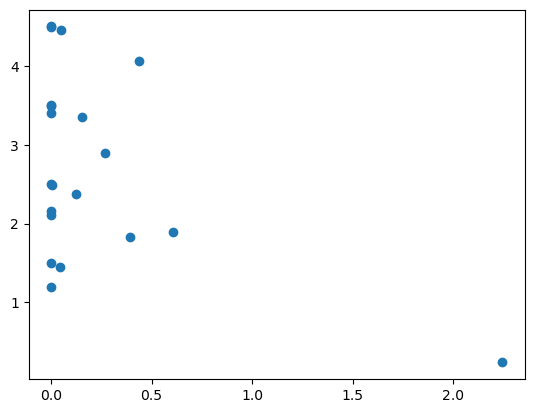

In [5]:
### Below function draws solutions in P
### In big size of N we can see how randomly generated solutions appear
### Please check it e.g. for N=10000.
### TODO Justify the distribution referring to the definition of the problem. 

def plotPopul(P: List[Solution]) -> None:
    plt.figure()
    X = [s.f[0] for s in P]
    Y = [s.f[1] for s in P]
    plt.plot(X, Y, ls='', marker='o')
    # plt.xlim(0, 3.0)
    # plt.ylim(0, 3.0)

plotPopul(P)

In [6]:
def calculateFronts(P: List[Solution]) -> None:
    # Initialize front counter
    front = 0

    # Reset dominating count and dominated solutions for all solutions
    for solution in P:
        solution.dominating_count = 0
        solution.dominated_solutions = []

    num_points = len(P)
    # Iterate over all pairs of solutions
    for i in range(num_points):
        for j in range(num_points):
            if i == j:
                continue
            if P[i].dominates(P[j]):
                # Solution i dominates solution j
                P[i].dominated_solutions.append(j)
            elif P[j].dominates(P[i]):
                # Solution j dominates solution i
                P[i].dominating_count += 1

        # If no solution dominates solution i, assign it to the first front
        if P[i].dominating_count == 0:
            P[i].front = front

    # Initialize current front index
    current_front = 0

    # Process each front until no more solutions can be assigned
    while True:
        next_front = []

        # Iterate over all solutions in the current front
        for solution in P:
            if solution.front == current_front:
                # Update dominating count for solutions dominated by the current solution
                for dominated_solution_index in solution.dominated_solutions:
                    dominated_solution = P[dominated_solution_index]
                    dominated_solution.dominating_count -= 1

                    # If the dominated solution has no more solutions dominating it, assign it to the next front
                    if dominated_solution.dominating_count == 0:
                        dominated_solution.front = front + 1
                        next_front.append(dominated_solution_index)

        # If there are no more solutions in the next front, break the loop
        if len(next_front) == 0:
            break

        # Update front index and move to the next front
        front += 1
        current_front += 1

def calculateCrowdingDistances(P: List[Solution]) -> None:
    if any([solution.front is None for solution in P]):
        calculateFronts(P)
    front = max([solution.front for solution in P])
    # Assign crowding distance values to solutions in each front
    for current_front in range(front + 1):
        current_solutions = [solution for solution in P if solution.front == current_front]
        objectives = np.array([solution.f for solution in current_solutions])

        for i in range(len(current_solutions)):
            current_solutions[i].cd = 0.0

        for objective_index in range(objectives.shape[1]):
            sorted_indices = np.argsort(objectives[:, objective_index])

            current_solutions[sorted_indices[0]].cd = float('inf')
            current_solutions[sorted_indices[-1]].cd = float('inf')

            for i in range(1, len(sorted_indices) - 1):
                current_solutions[sorted_indices[i]].cd += (
                    objectives[sorted_indices[i + 1], objective_index]
                    - objectives[sorted_indices[i - 1], objective_index]
                )

In [7]:
### TODO below function should return list of pairs of solution indices chosen for reproduction.
### From each pair there will be created one descendant individual.
### Selection should be made on the basis on tournament (size 2)
### Output: list of pairs -> [ [idx11, idx12],...,[idxN1, idxN2] ]

def constructParents(N: int):
    if any([solution.front is None for solution in P]):
        calculateFronts(P)
    num_pop = len(P)
    parents = []
    for _ in range(N):
        sublist_parents = []
        # Select two random solutions withou replacement
        idx1, idx2 = np.random.choice(num_pop, 2, replace=False)
        idx3, idx4 = np.random.choice(num_pop, 2, replace=False)
        # Select the one with the lower front
        if P[idx1].dominates(P[idx2]):
            sublist_parents.append(idx1)
        else:
            sublist_parents.append(idx2)
        if P[idx3].dominates(P[idx4]):
            sublist_parents.append(idx3)
        else:
            sublist_parents.append(idx4)
        parents.append(sublist_parents)
    return parents

        
    

print(constructParents(10)) ### TEST

[[17, 12], [6, 19], [2, 4], [6, 0], [14, 0], [9, 12], [6, 2], [6, 0], [3, 16], [6, 2]]


In [8]:
calculateFronts(P)
calculateCrowdingDistances(P)
for front in range(max([solution.front for solution in P]) + 1):
    front_solutions = [solution for solution in P if solution.front == front]
    print("Front", front + 1)
    for solution in front_solutions:
        print(solution)
    print()

Front 1
[0-0 : F = [7.81640212e-10 1.50000000e+00]]
[0-2 : F = [1.2681869e-13 3.4999977e+00]]
[0-6 : F = [1.85406804e-04 1.20170598e+00]]
[0-18 : F = [2.2439714  0.23910107]]

Front 2
[0-8 : F = [2.29550010e-09 2.10456847e+00]]
[0-12 : F = [1.28643029e-09 4.49999997e+00]]
[0-19 : F = [0.04400525 1.45597268]]

Front 3
[0-3 : F = [9.80878260e-05 2.16211486e+00]]
[0-5 : F = [0.39055821 1.83607845]]
[0-9 : F = [3.15710202e-05 2.49990915e+00]]
[0-10 : F = [1.25851782e-05 3.40406829e+00]]

Front 4
[0-4 : F = [0.00370675 2.48727661]]
[0-14 : F = [0.60666044 1.89333955]]
[0-15 : F = [1.95105179e-04 3.49746691e+00]]
[0-16 : F = [0.12359419 2.37204425]]

Front 5
[0-1 : F = [0.04664511 4.45335489]]
[0-11 : F = [1.51672960e-03 4.49848202e+00]]
[0-13 : F = [0.15204006 3.34759086]]
[0-17 : F = [0.26835687 2.89199303]]

Front 6
[0-7 : F = [0.4395688  4.06042838]]



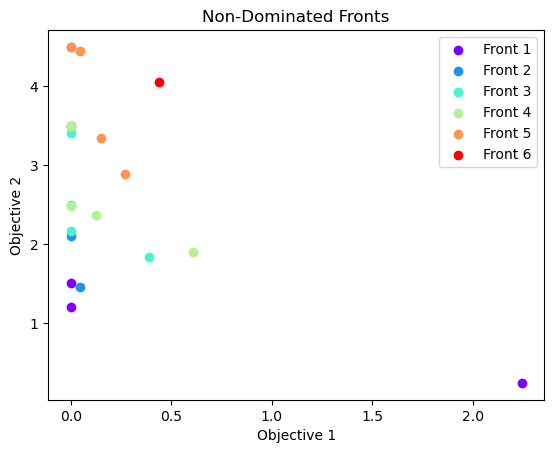

In [9]:
num_fronts = max([solution.front for solution in P]) + 1
colors = plt.cm.rainbow(np.linspace(0, 1, num_fronts))
for front in range(num_fronts):
    front_solutions = [solution for solution in P if solution.front == front]
    front_x = [solution.f[0] for solution in front_solutions]
    front_y = [solution.f[1] for solution in front_solutions]
    plt.scatter(front_x, front_y, color=colors[front], label='Front ' + str(front + 1))

plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Non-Dominated Fronts')
plt.legend()
plt.show()

In [10]:
# Make sure that the fronts are correct
matrix = [[solution for solution in P if solution.front == front] for front in range(num_fronts)]
# Check that the points inside each front are non-dominated with respect to each other and dominated by the points in the previous front
for front in range(num_fronts):
    for solution in matrix[front]:
        for other_solution in matrix[front]:
            if solution.dominates(other_solution):
                print("Error: Solution", solution, "dominates", other_solution, "in the same front")
            if other_solution.dominates(solution):
                print("Error: Solution", other_solution, "dominates", solution, "in the same front")
    if front > 0:
        for solution in matrix[front]:
            for other_solution in matrix[front - 1]:
                if solution.dominates(other_solution):
                    print("Error: Solution", solution, "dominates", other_solution, "in the previous front", front, front - 1)

In [11]:
# TODO below function should make a crossover of two input vectors
# There can be any type of crossover implemented.

def getCrossed(xA: List[float], xB: List[float]) -> List[float]:
    return 0.5 * (np.array(xA) + np.array(xB))

print(getCrossed([0.0, 0.5, 1.0], [1.0, 0.25, 0.75])) ### TEST

[0.5   0.375 0.875]


In [12]:
# TODO the below function should mutate the input vector x. 
# You need to take into account the probability of mutation for each decision variable.
# In case of binary variables, the mutation should be made as a complement to 1:
# new x[i] = 1 - x[i]
# In case of continuous variables, you can use gaussian mutation
# You need to have a protection from potential exceeding values out of  [0, 1] interval.

def mutate(x: List[float], prob: float, std: float) -> List[float]:
    for i in range(2):
        if np.random.rand() < prob:
            x[i] += np.random.normal(0.0, std)
            x[i] = np.clip(x[i], 0.0, 1.0)
    for i in range(2, 5):
        if np.random.rand() < prob:
            x[i] = 1 - x[i]

    return x

for std in [0.0, 0.1, 0.2]: ## TEST
    x = [0.0, 0.2, 1.0, 0.0, 0.0]
    mutate(x, 1.0, std)
    print(x)

[0.0, 0.2, 0.0, 1.0, 1.0]
[0.07340090088428423, 0.3346332594184157, 0.0, 1.0, 1.0]
[0.07477342572708287, 0.2698064284143725, 0.0, 1.0, 1.0]


In [13]:
### Please read the below method
### It generates the vector of descendant solutions basing on selected parents
### and chosen reproduction operators.

def constructOffspring(P: Solution, parents, gen, std: float) -> List[Solution]:
    O = []
    prob = 1.0 / 5.0
    for i in range(len(parents)):
        xO = getCrossed(P[parents[i][0]].x, P[parents[i][1]].x)
        mutate(xO, prob, std)
        O.append(Solution(xO, evaluate(xO), str(gen) + "-" + str(i)))
    return O

In [14]:
# Method for checking the existence of dominance relation
def dominates(sj: Solution, sk: Solution) -> bool:
    if sj.f[0] < sk.f[0] and sj.f[1] <= sk.f[1]:
        return True
    if sj.f[0] <= sk.f[0] and sj.f[1] < sk.f[1]: 
        return True
    return False

In [15]:
### TODO Below method should do the assignemnt of solutions to non-dominated fronts
### The output should be list of list of indices of solutions in P, assigned to proper fronts.
### E.g. the output  [[3,4,0],[1,5],[2]] means that the solutions with ids 0, 3 and 4 are in a first front,
### 1 and 5 in second front and 2 in the last one. 

def getNonDominatedFronts(P: List[Solution]) -> List[List[int]]:
    if any([solution.front is None for solution in P]):
        calculateFronts(P)
    num_fronts = max([solution.front for solution in P]) + 1
    return [[idx for idx, point in enumerate(P) if point.front == i] for i in range(num_fronts)]

getNonDominatedFronts(P)

[[0, 2, 6, 18],
 [8, 12, 19],
 [3, 5, 9, 10],
 [4, 14, 15, 16],
 [1, 11, 13, 17],
 [7]]

In [16]:
### TODO below method should calculate values of crowding distance (CD) for solutions in P.
### ATTENTION: CD is calculated for each non-dominated front separately;
### Method should return the vector of calculated CD

def getCrowdingDistances(F: List[int], P: List[Solution]) -> List[float]:
    if any([solution.cd is None for solution in P]):
        calculateCrowdingDistances(P)
    return [point.cd for point in P]

In [17]:
### Below method assigns to solutions their numbers of non-dominated fronts and crowding 
# distances values then sort solutions in the population basing on these metrics.
# In case useCD = False, crowding distances is not taken into account while sorting.
# Testing the method for useCD = True and False let us see the gain 
# coming from the usage of crowding distances.

def applyScoresAndSort(P: List[Solution], useCD: bool = True) -> None:
    F = getNonDominatedFronts(P)
    CD = [0 for _ in P]
    if useCD:
        CD = getCrowdingDistances(F, P)
        CD_filtered = [v for v in CD if v != float('inf')]
        mi, ma = min(CD), max(CD_filtered) ### crowding distances normalization
        if abs(mi - ma) < 0.00001: CD = [0.5 for _ in range(len(P))]
        CD = [(v-mi)/(ma-mi) for v in CD]    

    for s, f in enumerate(F):
         for i in f: 
            P[i].front = s
            P[i].cd = CD[i]
   
    P.sort(key=lambda x: x.front - x.cd * 0.5) # Kryterium sortowania

In [18]:
# TODO Below method should calculate additional statistics which may help
# justify the usage of crowding distances in calculations.
# The method should return average, max and min crowding distances value  
# for the solutions and std dev in population P.
# While calculations, omit the boundary values (inf).
# How can we interpret these measures?

def getStatsCD(P: List[Solution]) -> Tuple[float, float, float, float]:
    if any([solution.cd is None for solution in P]):
        calculateCrowdingDistances(P)
    CD = [solution.cd for solution in P]
    CD = [x for x in CD if x != np.inf]
    if len(CD) == 0:
        print("All crowding distances are inf")
        return (0.0, 0.0, 0.0, 0.0)
    return (np.mean(CD), np.max(CD), np.min(CD), np.std(CD))

getStatsCD(P)

(1.8575529886659874, 3.5048703279324114, 1.054357333409723, 0.8542699779755628)

These two cells below show how NSGA-II algoritm works, illustrate created solutions  in 5 different stages of algorithm and finally write stats for CD. In the first cell CD is not used  while sorting and in the second it is used. You need to read the code and test it for different values of parameters (e.g. population size).
For which variant the algorithm works best?

**Additional task:** evolutionary algorithms are random. That is why running them one time may not be credible. To get more credible result, the algorithm may be run e.g. 20 times and the statistics averaged. Additionally, you can calculate them for each generation and plot their convergence. Moreover, you can plot this for both varinats of algorithm (with and without CD).

However, the stats for CD may not be the best way for scoring the algorithm. You can see that the solutions are highly scattered at the beginning and their CD values are high which is not compatible with the assumption that the higher value, of CD, the better. For better algorithm evaluation, you can use metrics which estimate the distance to Pareto front. You can propose such a method and use it to show the closeness of population to this front. Then when you get this metic and metrics for scoring the dispersion of solutions, you can better compare algorithms.

(0.021186883745469922, 0.09397465762077979, 0.0019522864983961274, 0.016151202160180244)


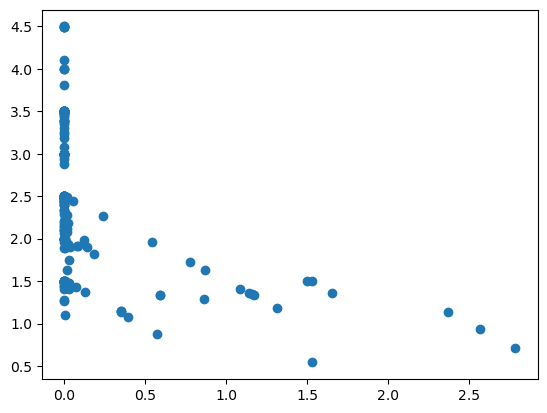

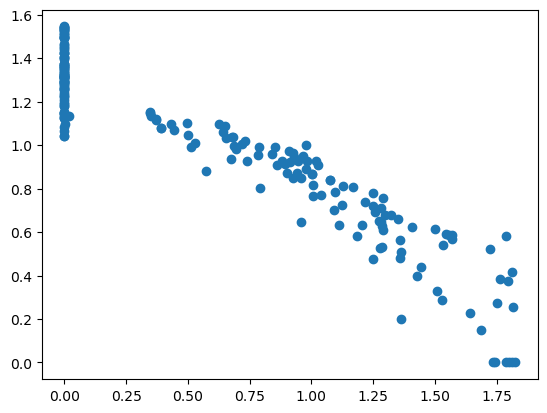

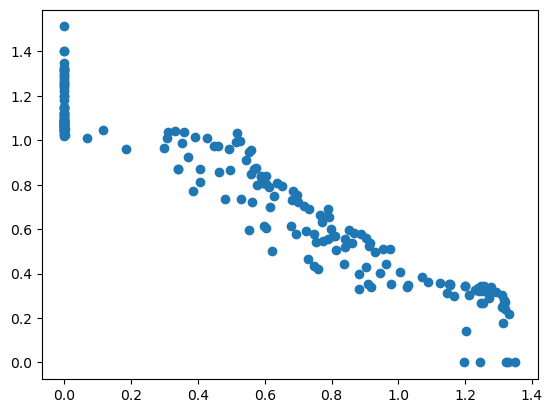

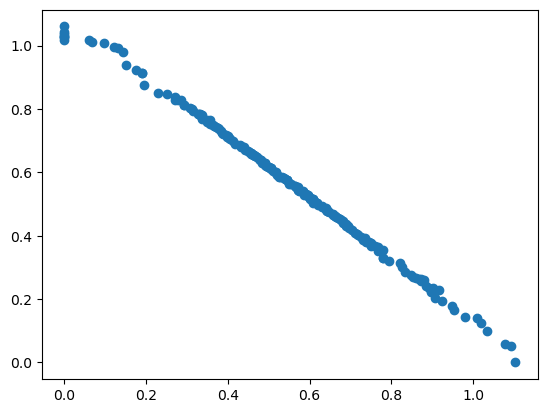

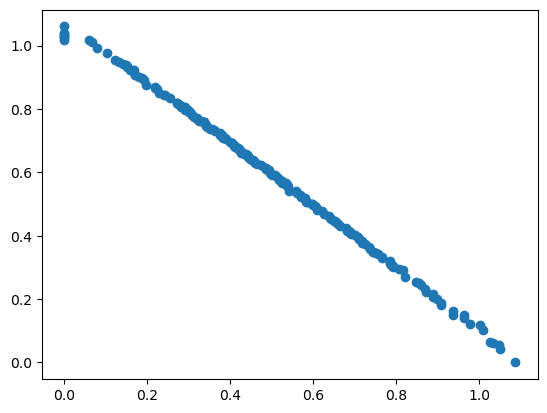

In [19]:
### Omitting CD
N = 200 # population size
GEN = 100 # generation number/ number of iterations
 
P = constructInitialPopulation(N)
calculateCrowdingDistances(P)
applyScoresAndSort(P, useCD = False) 

for gen in range(GEN): 
    C = constructParents(N)
    O = constructOffspring(P, C, gen + 1, 0.1) 
    M = P + O
    applyScoresAndSort(M, useCD = False)
    P = M[:N] # get N best individuals
    calculateFronts(P)
    calculateCrowdingDistances(P)
    if gen % (GEN / 4) == 0 or gen == GEN - 1: 
        plotPopul(P) # step size for population illustration

# print stats
print(getStatsCD(P))

(0.009195743018043632, 0.050312162379350205, 0.0009281450646077846, 0.008753367854491725)


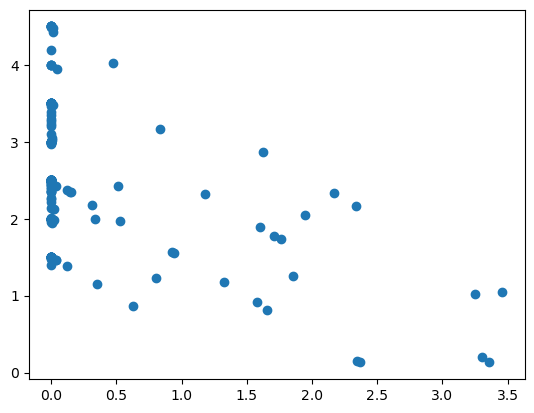

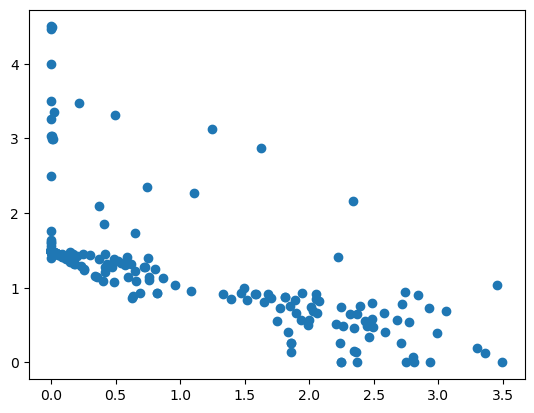

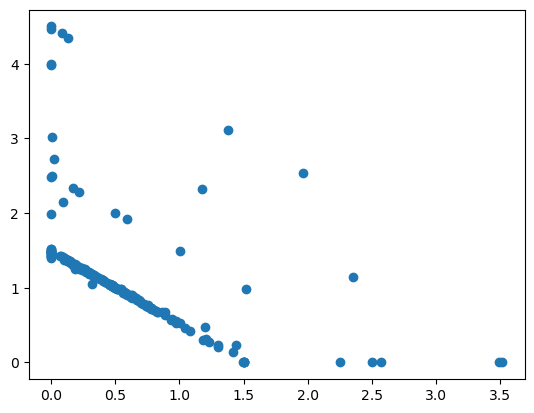

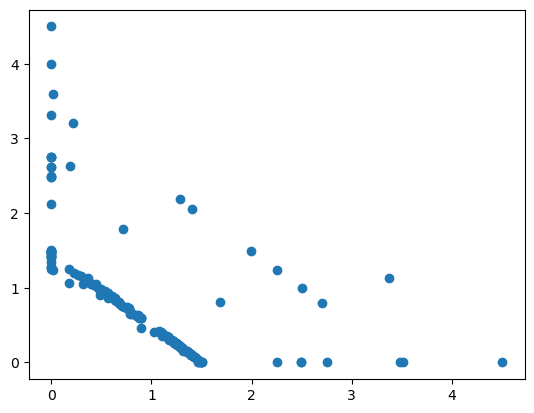

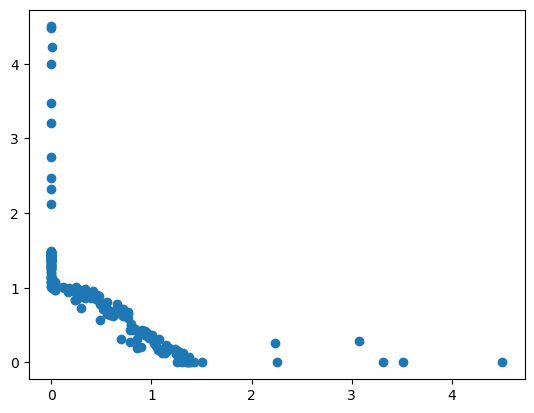

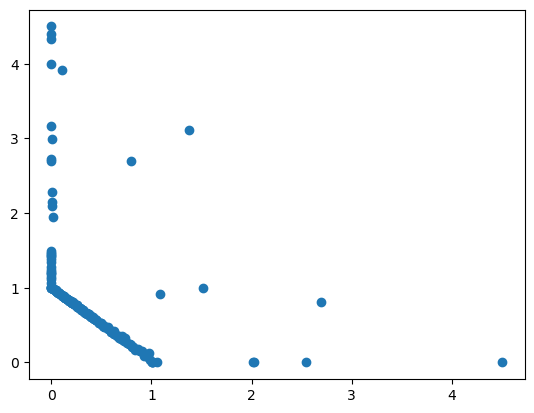

In [20]:
### With CD
N = 200
GEN = 100

P = constructInitialPopulation(N)
calculateCrowdingDistances(P)
applyScoresAndSort(P, useCD = True)

for gen in range(GEN):
    C = constructParents(N)
    O = constructOffspring(P, C, gen + 1, 0.1)
    M = P + O
    applyScoresAndSort(M, useCD = True)
    P = M[:N]
    calculateFronts(P)
    if gen % (GEN / 5) == 0 or gen == GEN - 1: 
        plotPopul(P)

print(getStatsCD(P))